# Run a Periodogram Across Full ZTF Sources

This notebook is an adaptation of the Nested Dask [tutorial for loading HiPSCat data](https://nested-dask.readthedocs.io/en/latest/tutorials/work_with_lsdb.html).

There we loaded a small subset of ZTF DR 14, and here we will try to load a full ZTF DR 20 and run a `light-curve` package periodogram across all of ZTF on PSC Bridges2.


Performance spreadsheet
https://docs.google.com/spreadsheets/d/19-GexwAu1TBunGKkCNMU7c3uwhbcLwZXteLLvT3Q48w/edit?usp=sharing

## Install dependencies for the notebook

The notebook requires `nested-dask` and few other packages to be installed.
- `lsdb` to load and join "object" (pointing) and "source" (detection) ZTF catalogs
- `aiohttp` is `lsdb`'s optional dependency to download the data via web
- `light-curve` to extract features from light curves
- `matplotlib` to plot the results

In [1]:
# Comment the following line to skip dependencies installation
%pip install --quiet --only-binary=light-curve tqdm aiohttp light-curve matplotlib dask-jobqueue

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip uninstall -y --quiet lsdb hipscat
# %pip install --quiet git+https://github.com/astronomy-commons/lsdb.git
%pip install lsdb

Note: you may need to restart the kernel to use updated packages.
  Using cached lsdb-0.4.1-py3-none-any.whl.metadata (5.9 kB)
Using cached lsdb-0.4.1-py3-none-any.whl (70 kB)
Note: you may need to restart the kernel to use updated packages.


In [15]:
%pip install -U git+https://github.com/lincc-frameworks/nested-pandas@non-uniq-idx

  Cloning https://github.com/lincc-frameworks/nested-pandas (to revision non-uniq-idx) to /var/tmp/pip-req-build-q_3r95k6
  Running command git clone --filter=blob:none --quiet https://github.com/lincc-frameworks/nested-pandas /var/tmp/pip-req-build-q_3r95k6
  Running command git checkout -b non-uniq-idx --track origin/non-uniq-idx
  Switched to a new branch 'non-uniq-idx'
  branch 'non-uniq-idx' set up to track 'origin/non-uniq-idx'.
  Resolved https://github.com/lincc-frameworks/nested-pandas to commit a6b83d88eeacd9478a436314959bfcb140f197dc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nested-pandas: filename=nested_pandas-0.2.3.dev33+ga6b83d8-py3-none-any.whl size=37213 sha256=8d1d205e654706325ce54c950715980fb76a90cd18411a39c3356c21f6e2c933
  Stored in directory: /var/tmp/pip-ephem-wheel-cache-kx7xnd9p/wheels/fd/56/c0/357cb270d65ce281caf5b21a3c9b687fb4010e656325e43061
Succe

In [3]:
import os
from importlib.metadata import version
from pathlib import Path

import dask.array
import dask.distributed
import dask_jobqueue
import light_curve as licu
import matplotlib.pyplot as plt
import nested_pandas as npd
import numpy as np
import pandas as pd
from lsdb import read_hats
from matplotlib.colors import LogNorm
from nested_dask import NestedFrame

In [4]:
print(f"{version('lsdb') = }")
print(f"{version('nested-dask') = }")
print(f"{version('dask') = }")

version('lsdb') = '0.4.1'
version('nested-dask') = '0.2.0'
version('dask') = '2024.8.2'


Some additional setup for using Dask on PSC Bridges2:

In [5]:
from tqdm import tqdm
import dask
dask.config.set({
    "temporary-directory": Path(os.environ["LOCAL"]) / "dask",
    'distributed.comm.timeouts.connect': '600s',
    'distributed.comm.timeouts.tcp': '600s',
})

#from dask.diagnostics import ProgressBar
#ProgressBar().register()
# Unclear how we want shuffle compression configured
#dask.config.set({"dataframe.shuffle-compression": 'Snappy'})

## Load ZTF DR14
For the demonstration purposes we use a light version of the ZTF DR14 catalog distributed by LINCC Frameworks, a half-degree circle around RA=180, Dec=10.
We load the data from HTTPS as two LSDB catalogs: objects (metadata catalog) and source (light curve catalog).

## Setup cone search
Here we use a cone search for the LSDB load to keep our data small

In [6]:
from lsdb.core.search import ConeSearch
# search_area = ConeSearch(ra=254, dec=35, radius_arcsec=2.0 * 3600)
search_area = None

In [7]:
# catalogs_dir = "/data3/epyc/data3/hipscat/catalogs/ztf_axs"
catalogs_dir = "/ocean/projects/phy210048p/shared/hats/catalogs/ztf_dr14"


object_catalog = read_hats(
    f"{catalogs_dir}/ztf_object",
    columns=["ra", "dec", "ps1_objid"],
    search_filter=search_area,
)
source_catalog = read_hats(
    f"{catalogs_dir}/ztf_source",
    columns=["mjd", "ra", "dec", "mag", "magerr", "band", "ps1_objid", "catflags"],
    search_filter=search_area,
)
lc_columns = ["mjd", "mag", "magerr", "band", "catflags"]

In [8]:
source_catalog

,mjd,ra,dec,mag,magerr,band,ps1_objid,catflags
npartitions=41679,,,,,,,,
0,double[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],int64[pyarrow],int16[pyarrow]
1125899906842624,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
3458483038843830272,...,...,...,...,...,...,...,...
3458764513820540928,...,...,...,...,...,...,...,...


We need to merge these two catalogs to get the light curve data.
It is done with LSDB's `.join_nested()` method which would give us a new catalog with a nested frame of ZTF sources. For this tutorial we'll just use the underlying nested dataframe for the rest of the analysis rather than the LSDB catalog directly.

In [9]:
# Nesting Sources into Object
ztf_nested = object_catalog.join_nested(
    source_catalog,
    left_on="ps1_objid",
    right_on="ps1_objid",
    nested_column_name="lc",
)
ztf_nested

/ocean/projects/phy210048p/malanche/lsdb-tests/cenv/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,ra,dec,ps1_objid,lc
npartitions=41679,,,,
0,double[pyarrow],double[pyarrow],int64[pyarrow],"nested<mjd: [double], ra: [double], dec: [doub..."
1125899906842624,...,...,...,...
...,...,...,...,...
3458483038843830272,...,...,...,...
3458764513820540928,...,...,...,...


## Convert LSDB joined catalog to `nested_dask.NestedFrame`

First, we plan the computation to convert the joined Dask DataFrame to a NestedFrame.

Now we filter our dataframe by the `catflags` column (0 flags correspond to the perfect observational conditions) and the `band` column to be equal to `r`.
After filtering the detections, we are going to count the number of detections per object and keep only those objects with more than 10 detections.

In [10]:
r_band = ztf_nested.query("lc.catflags == 0 and lc.band == 'r'")
nobs = r_band.reduce(lambda mjd: {"nobs": np.size(mjd)}, "lc.mjd", meta={"nobs": int})
r_band = r_band[nobs["nobs"] > 10]
r_band

,ra,dec,ps1_objid,lc
npartitions=41679,,,,
0,double[pyarrow],double[pyarrow],int64[pyarrow],"nested<mjd: [double], ra: [double], dec: [doub..."
1125899906842624,...,...,...,...
...,...,...,...,...
3458483038843830272,...,...,...,...
3458764513820540928,...,...,...,...


Later we are going to extract features, so we need to prepare light-curve data to be in the same float format.

### Extract features from ZTF light curves

Now we are going to extract some features:
- Top periodogram peak
- Mean magnitude
- Von Neumann's eta statistics
- Excess variance statistics
- Number of observations

We are going to use [`light-curve`](https://github.com/light-curve/light-curve-python) package for this purposes

In [11]:
%%time

extractor = licu.Extractor(
    licu.Periodogram(
        peaks=1,
        max_freq_factor=1.0, # Currently 1.0 for fast runs, will raise for more interesting graphs later
        fast=True,
    ),  # Would give two features: peak period and signa-to-noise ratio of the peak
)


# light-curve requires all arrays to be the same dtype.
# It also requires the time array to be ordered and to have no duplicates.
def extract_features(mjd, mag, **kwargs):
    # We offset date, so we still would have <1 second precision
    t = np.asarray(mjd - 60000, dtype=np.float32)
    _, sort_index = np.unique(t, return_index=True)
    features = extractor(
        t[sort_index],
        mag[sort_index],
        **kwargs,
    )
    # Return the features as a dictionary
    return dict(zip(extractor.names, features))


r_band_w_features = r_band.reduce(
    extract_features,
    "lc.mjd",
    "lc.mag",
    meta={name: np.float32 for name in extractor.names},
    append_columns=True,
)
r_band_w_features

CPU times: user 44.9 ms, sys: 2.73 ms, total: 47.7 ms
Wall time: 163 ms


,ra,dec,ps1_objid,lc,period_0,period_s_to_n_0
npartitions=41679,,,,,,
0,double[pyarrow],double[pyarrow],int64[pyarrow],"nested<mjd: [double], ra: [double], dec: [doub...",float32,float32
1125899906842624,...,...,...,...,...,...
...,...,...,...,...,...,...
3458483038843830272,...,...,...,...,...,...
3458764513820540928,...,...,...,...,...,...


Before we are going next and actually run the computation, let's create a Dask client which would allow us to run the computation in parallel.

Now we can collect some statistics and plot it. 

In [12]:
%%time

lg_period_bins = np.linspace(-1, 2, 101)
lg_snr_bins = np.linspace(0, 2, 101)

lg_period = dask.array.log10(r_band_w_features["period_0"].to_dask_array())
lg_snr = dask.array.log10(r_band_w_features["period_s_to_n_0"].to_dask_array())

hist2d_dask = dask.array.histogram2d(
    lg_period,
    lg_snr,
    bins=[lg_period_bins, lg_snr_bins],
)

CPU times: user 6min 51s, sys: 20.3 s, total: 7min 11s
Wall time: 7min 12s


In [18]:
class Job(dask_jobqueue.slurm.SLURMJob):
    # Rewrite the default, which is a property equal to cores/processes
    worker_process_threads = 1
    
    
class Cluster(dask_jobqueue.SLURMCluster):
    job_cls = Job


gb_per_job = 32
jobs = 56
processes = 2
gb_per_core = 2  # PSC "regular memory" nodes provide fixed 2GB / core
cluster = Cluster(
    # Number of Dask workers per node
    processes=processes,
    # Regular memory node type on PSC bridges2
    queue="RM-shared",
    # dask_jobqueue requires cores and memory to be specified
    # We set them to match RM specs
    cores=gb_per_job // gb_per_core,
    memory=f"{gb_per_job}GB",
    walltime="4:00:00",
)

# processes = 8
# jobs = 3
# cluster = SLURMCluster(
#     # Number of Dask workers per node
#     processes=processes,
#     # Regular memory node type on PSC bridges2
#     queue="RM",
#     # dask_jobqueue requires cores and memory to be specified
#     # We set them to match RM specs
#     cores=128,
#     memory=f"256GB",
#     walltime="1:00:00",
# )

# Run multiple jobs
cluster.scale(jobs=jobs)
# Allow to run more jobs
# cluster.adapt(maximum_jobs=100)
client = dask.distributed.Client(cluster)
print(client)
# Wait all workers to start
cluster.wait_for_workers(jobs * processes)



# client = dask.distributed.Client(n_workers=8, threads_per_worker=8)



client

<Client: 'tcp://10.8.10.154:42265' processes=0 threads=0, memory=0 B>


<Client: 'tcp://10.8.10.154:42265' processes=84 threads=84, memory=1.22 TiB>

In [19]:
%%time

# Run the computation
hist2d = hist2d_dask[0].compute()

/ocean/projects/phy210048p/malanche/lsdb-tests/cenv/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 76.76 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 1h 33min 29s, sys: 4min 56s, total: 1h 38min 26s
Wall time: 2h 3min 26s


Text(0, 0.5, 'lg S/N')

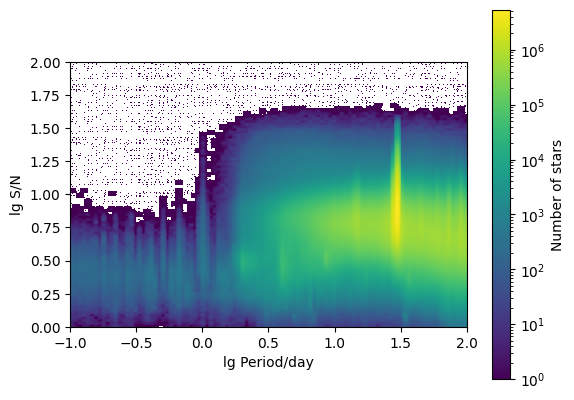

In [20]:
# Plot the 2D histogram
plt.imshow(
    hist2d.T,
    extent=(lg_period_bins[0], lg_period_bins[-1], lg_snr_bins[0], lg_snr_bins[-1]),
    origin="lower",
    norm=LogNorm(vmin=1, vmax=hist2d.max()),
)
plt.colorbar(label="Number of stars")
plt.xlabel("lg Period/day")
plt.ylabel("lg S/N")

In [21]:
client.close()

In [22]:
cluster.close()

TimeoutError: join timed out

In [ ]:
hist2d.sum()